# **Intro**

In this notebook I will try to understand why some cell types are almost always 0 in the pseudobulk decomposition.
I believe this is due to feature selection issues or uninformative cells being included in the pseudobulk generation.

In [1]:
# import out preprocessing code
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess
import evaluation_experiments.pbmc.pbmc_generate_data as gen_data

# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from argparse import ArgumentParser
from importlib import reload
from functools import reduce

import pickle
import gzip
from pathlib import Path

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import pickle
import gzip
from pathlib import Path

# set seeds
from numpy.random import seed
seed(1)

In [2]:
# code for reading in the single cell data

def get_genes(GSE_data_path, exp_id, min_num_cells):

    # these are pre-defined parameters that are inherent
    # to each experiment
    pbmc1_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                        "Experiment":'pbmc1', 
                        "num_cells":[253],
                        "file_id":'pbmc_rep1_sm2'})

    pbmc2_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[273],
                        "file_id":'pbmc_rep2_sm2'})

    pbmc1_10x_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                        "Experiment":'pbmc1', 
                        "num_cells":[3222],
                        "file_id":'pbmc_rep1_10xV2a'})

    pbmc1_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                        "Experiment":'pbmc1', 
                        "num_cells":[3222],
                        "file_id":'pbmc_rep1_10xV2a_sm2_cells'})

    pbmc2_10x_param = pd.DataFrame({"Method":'10x Chromium V2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[3362],
                        "file_id":'pbmc_rep2_10xV2'})

    pbmc2_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2', 
                        "Experiment":'pbmc2', 
                        "num_cells":[3362],
                        "file_id":'pbmc_rep2_10xV2_sm2_cells'})

    sm2_cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                    'CD16+ monocyte', 'B cell',
                    'CD4+ T cell', 'Megakaryocyte']

    #####################
    ### set the study ###
    #####################
    cell_file = os.path.join(GSE_data_path, "GSE132044_cells_umi_new.txt")
    count_file = os.path.join(GSE_data_path, "GSE132044_counts_umi.txt.gz")
    gene_file = os.path.join(GSE_data_path, "GSE132044_genes_umi.txt")
    meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
    meta_tsne_file = os.path.join(GSE_data_path, "GSE132044_meta.txt")


    if exp_id == "pbmc_rep1_sm2" :
        curr_study = pbmc1_smart_seq2_param
        cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
        count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
        gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
    elif exp_id == "pbmc_rep2_sm2" :
        curr_study = pbmc2_smart_seq2_param
        cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
        count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
        gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
    elif exp_id == "pbmc_rep1_10xV2a":
        curr_study = pbmc1_10x_param
    elif exp_id == "pbmc_rep1_10xV2a_sm2_cells":
        curr_study = pbmc1_10x_sm2_cells_param
    elif exp_id == "pbmc_rep2_10xV2":
        curr_study = pbmc2_10x_param
    elif exp_id == "pbmc_rep2_10xV2_sm2_cells":
        curr_study = pbmc2_10x_sm2_cells_param
    else:
        assert False, "Unrecognized experiment ID"


    # set the study specific parameters
    num_cells_expected = pd.to_numeric(curr_study["num_cells"][0])
    method_keep = curr_study["Method"].tolist()
    experiment_keep = curr_study["Experiment"].tolist()

    # read in the data
    cell_info, count_matr, gene_info, meta_info = gen_data.read_gse_input(cell_file, 
                                                                count_file, 
                                                                gene_file, 
                                                                meta_file, 
                                                                meta_tsne_file)

    # format the data
    pbmc1_a_dense = gen_data.format_cell_reads_info(meta_info, cell_info, count_matr, 
                                                    num_cells_expected, method_keep, 
                                                    experiment_keep)

    # get the gene names that pass
    pbmc1_a_expr, gene_pass = gen_data.filter_by_expr(pbmc1_a_dense, -1, gene_info)

    # get cell type info
    pbmc1_a_df, _ = gen_data.join_metadata(cell_info, meta_info, pbmc1_a_expr, gene_pass)

    # filter to sm2 cell types if needed
    if exp_id == "pbmc_rep1_10xV2a_sm2_cells" or exp_id == "pbmc_rep2_10xV2_sm2_cells":
        pbmc1_a_df = pbmc1_a_df[pbmc1_a_df['CellType'].isin(sm2_cell_types)]


    # get the gene names that pass
    pbmc1_a_df_num = pbmc1_a_df.drop("CellType", axis=1)
    pbmc1_a_df_num = pbmc1_a_df_num.transpose()
    pbmc1_a_binary = np.where(pbmc1_a_df_num>0,1,0)
    pbmc1_a_df_num = pbmc1_a_df_num[pbmc1_a_binary.sum(axis=1) > min_num_cells]

    # return the numeric df as well
    col_idx = pd.Index(['CellType'])
    col_idx = col_idx.append(pbmc1_a_df_num.index)

    return pbmc1_a_df_num.index, pbmc1_a_df[col_idx]

def get_variable_genes(inter_genes, num_genes, expr_df, cell_types):


    union_genes = []
    for cell_type in cell_types:

        cell_type_expr = expr_df.loc[expr_df['CellType'] == cell_type]
        cell_type_expr = cell_type_expr[inter_genes]
        cell_type_expr = cell_type_expr.to_numpy()

        X_colmean = cell_type_expr.mean(axis=0)
        X_colvar = cell_type_expr.var(axis=0)
        X_CoV = np.array(np.divide(X_colvar, X_colmean))
        idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
        cell_type_expr = cell_type_expr[:,idx_top]
        index_res = inter_genes[idx_top]
        index_res = index_res.tolist()
        union_genes.append(index_res)

    union_genes = reduce(np.union1d, union_genes)

    return(union_genes)


def get_variable_genes_bulk(inter_genes, num_genes, expr_df):

    expr_df_num = expr_df[inter_genes]
    expr_df_num = expr_df_num.to_numpy()

    expr_df_num = expr_df_num.transpose()
    scaled_val = (expr_df_num*10000) / expr_df_num.sum(axis = 0)
    expr_df_num = scaled_val.transpose()

    expr_df_num = np.log2(expr_df_num+1)

    X_colmean = expr_df_num.mean(axis=0)
    X_colvar = expr_df_num.var(axis=0)
    X_CoV = np.array(np.divide(X_colvar, X_colmean))
    idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
    expr_df_num = expr_df_num[:,idx_top]
    index_res = inter_genes.iloc[idx_top]
    index_res = index_res.tolist()

    return index_res, X_CoV


# **Analysis of feature selection using 10x cells**

In this section, 

1. I will plot raw 10x expression and identify the cell-type specific missingness. I will look for outlier cells/genes

2. After removing outlier cells / genes I will take the most variable genes in 10x per cell type. These are the features for all subsequent sections.

3. Cluster sm2 single cell expression using those features -- cell types should cluster together




In [19]:
def get_filtered_stats(expr_df, cell_types, index_res, exp_id):
    result_list = []
    remaining_genes = []
    for cell_type in cell_types:
        # each row is a cell, col is gene
        cell_type_expr = expr_df.loc[expr_df['CellType'] == cell_type]
        cell_type_num = cell_type_expr[index_res]
        num_genes = cell_type_num.shape[1]
        num_cells = cell_type_num.shape[0]+1

        # how many cells have at least 500 genes expressed?
        cell_type_num = cell_type_expr[index_res]
        cell_type_binary = np.where(cell_type_num>0,1,0)
        cell_type_num_cells = cell_type_num[cell_type_binary.sum(axis=1) > 500]

        # how many genes are in at least 5 cells
        cell_type_num_genes = cell_type_num_cells.transpose()
        cell_type_binary = cell_type_binary.transpose()
        cell_type_num_genes = cell_type_num_genes[cell_type_binary.sum(axis=1) > 5]
        remaining_genes.append(cell_type_num_genes.index.tolist())


        result_list.append([exp_id, cell_type, num_genes, num_cells, 
                                            cell_type_num_genes.shape[0], 
                                            cell_type_num_genes.shape[0]/num_genes,
                                            cell_type_num_cells.shape[0], 
                                            cell_type_num_cells.shape[0]/num_cells])


    result_df = pd.DataFrame(result_list, columns=['samp_id', 'CellType', 'tot_genes', 'tot_cells',
                                                    'num_genes_remain', 'percent_genes_remain',
                                                    'num_cells_remain', 'percent_cells_remain'])
    return result_df, remaining_genes

## raw data overview

In [23]:
GSE_data_path=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/"
aug_data_path=f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"

# read in the single cell expression
# only keep genes that are expressed in at least one cell
min_num_cells = 1

cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                'CD16+ monocyte', 'B cell',
                'CD4+ T cell', 'Megakaryocyte']

# now for each cell type, lets get some summary stats cell type lets get some features
# how many cells have less than 500 detected genes
# how many genes are not expressed in at least 5 cells

exp_id = 'pbmc_rep2_10xV2_sm2_cells'
rep2_10x_index_res, rep2_10x_expr_df = get_genes(GSE_data_path, exp_id, min_num_cells)
rep2_10x_stats, rep2_10x_genes = get_filtered_stats(rep2_10x_expr_df, cell_types, rep2_10x_index_res, exp_id)


exp_id = 'pbmc_rep1_10xV2a_sm2_cells'
rep1_10x_index_res, rep1_10x_expr_df = get_genes(GSE_data_path, exp_id, min_num_cells)
rep1_10x_stats, rep1_10x_genes = get_filtered_stats(rep1_10x_expr_df, cell_types, rep1_10x_index_res, exp_id)


exp_id = 'pbmc_rep1_sm2'
rep1_sm2_index_res, rep1_sm2_expr_df = get_genes(GSE_data_path, exp_id, min_num_cells)
rep1_sm2_stats, rep1_sm2_genes = get_filtered_stats(rep1_sm2_expr_df, cell_types, rep1_sm2_index_res, exp_id)


all_res = pd.concat([rep2_10x_stats, rep1_10x_stats, rep1_sm2_stats])
all_res.sort_values(by=['CellType'])

Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22757, 3362)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (20430, 3222)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22654, 253)


,samp_id,CellType,tot_genes,tot_cells,num_genes_remain,percent_genes_remain,num_cells_remain,percent_cells_remain
3,pbmc_rep1_sm2,B cell,19102,23,2727,0.142760,22,0.956522
3,pbmc_rep2_10xV2_sm2_cells,B cell,19485,863,12520,0.642546,829,0.960603
3,pbmc_rep1_10xV2a_sm2_cells,B cell,17565,289,7340,0.417876,242,0.837370
0,pbmc_rep2_10xV2_sm2_cells,CD14+ monocyte,19485,437,10353,0.531332,397,0.908467
0,pbmc_rep1_sm2,CD14+ monocyte,19102,35,6266,0.328028,34,0.971429
0,pbmc_rep1_10xV2a_sm2_cells,CD14+ monocyte,17565,641,8834,0.502932,403,0.628705
2,pbmc_rep1_sm2,CD16+ monocyte,19102,9,1213,0.063501,8,0.888889
2,pbmc_rep1_10xV2a_sm2_cells,CD16+ monocyte,17565,103,4767,0.271392,100,0.970874
2,pbmc_rep2_10xV2_sm2_cells,CD16+ monocyte,19485,51,4608,0.236490,50,0.980392
4,pbmc_rep1_sm2,CD4+ T cell,19102,59,7486,0.391896,58,0.983051


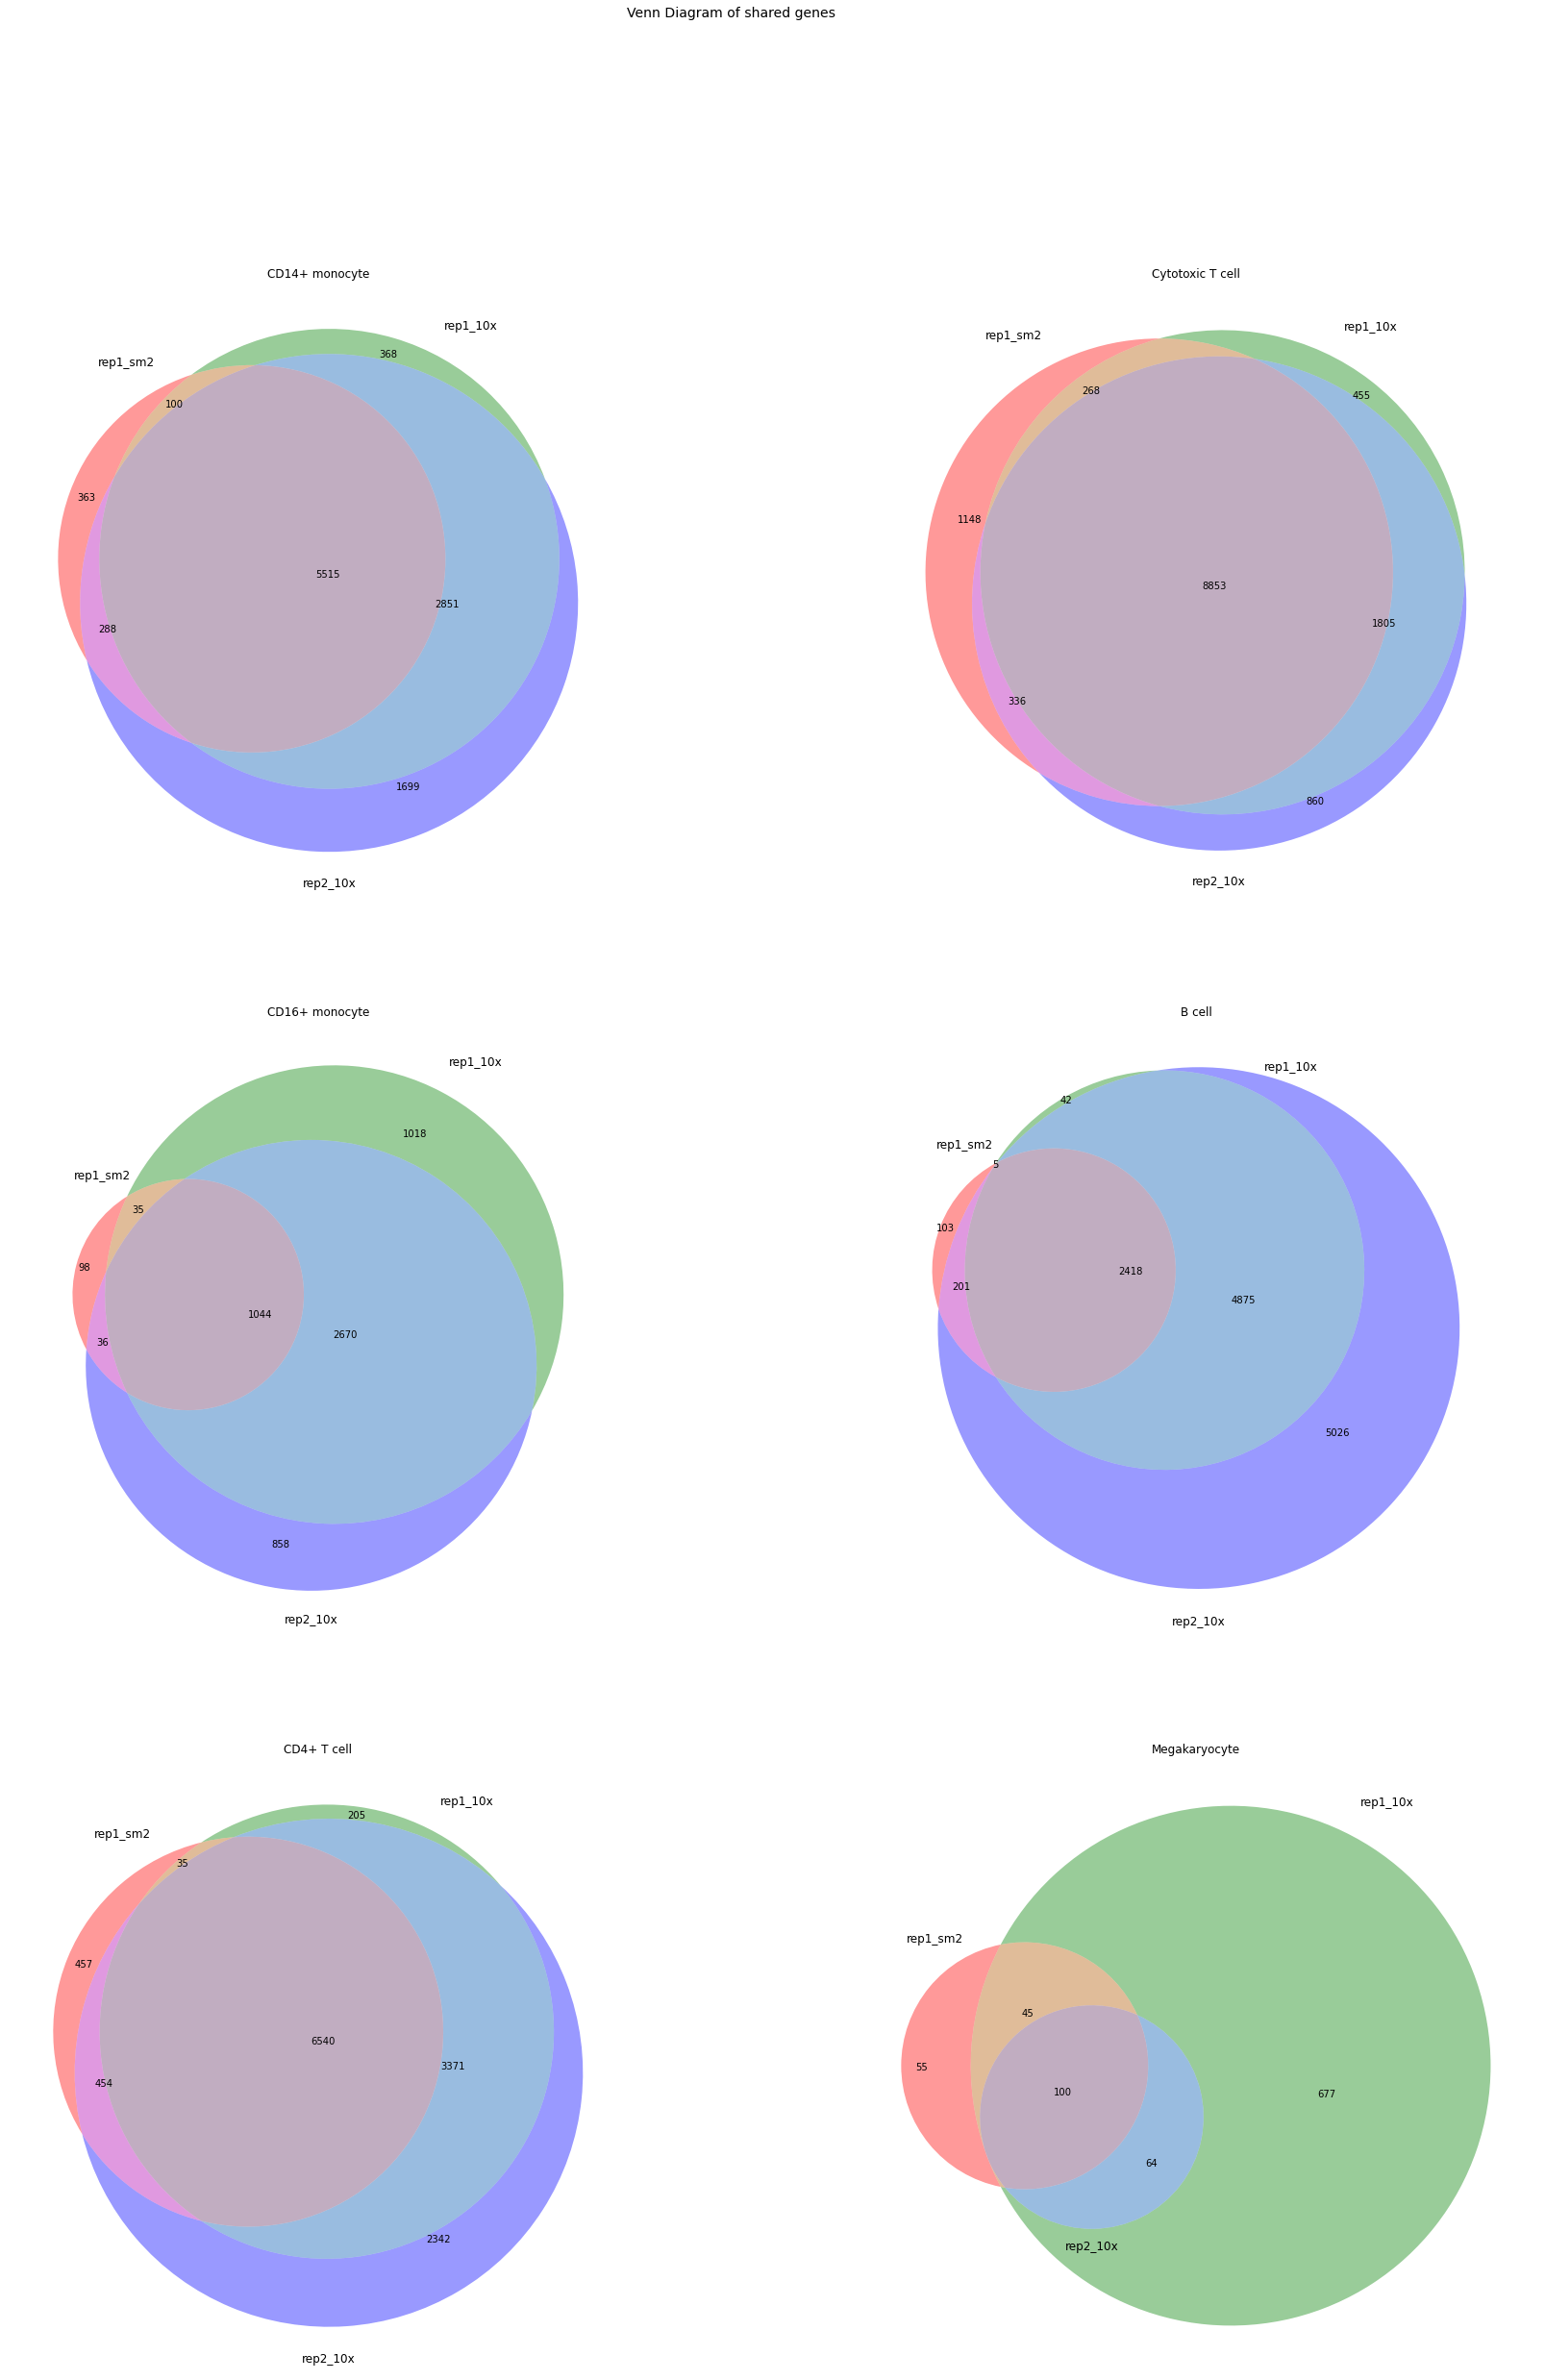

In [24]:
from matplotlib_venn import venn3

def get_sets_for_venn(idx, list1, list2, list3):
    set1 = set(list1[idx])
    set2 = set(list2[idx])
    set3 = set(list3[idx])
    return [set1, set2, set3]

def plot_venn(list_of_sets, name_of_sets, ax, title):
    g = venn3(list_of_sets, name_of_sets, ax=ax)
    ax.set_title(title)
    return g



fig, axs = plt.subplots(3, 2, figsize=(30,40))

idx = 0
set_names = ["rep1_sm2", "rep1_10x", "rep2_10x"]
for cell_type in cell_types:
    list_of_sets = get_sets_for_venn(idx, rep1_sm2_genes, 
                                    rep1_10x_genes, rep2_10x_genes)

    x_idx = np.floor(idx / 2).astype(int)
    y_idx = np.floor(idx % 2).astype(int)
    plot_venn(list_of_sets, set_names,
                ax=axs[x_idx, y_idx], title=cell_type)
    idx = idx +1

fig.suptitle("Venn Diagram of shared genes", fontsize=14)

plt.show()



## cluster cell types
Now take most variable genes in rep2_10x and try to cluster all other samples

In [6]:
# first we must do feature selection -- 
# lets first filter out cells and genes we dont want

def filter_cells(expr_df, index_res, min_num_genes):

    # how many cells have at least 500 genes expressed?
    cell_type_num = expr_df[index_res]
    cell_type_binary = np.where(cell_type_num>0,1,0)
    cell_type_expr_cells = expr_df[cell_type_binary.sum(axis=1) > min_num_genes]

    return cell_type_expr_cells


def filter_genes(inter_genes, num_cells, expr_df, cell_types):


    union_genes = []
    for cell_type in cell_types:

        cell_type_expr = expr_df.loc[expr_df['CellType'] == cell_type]
        cell_type_expr = cell_type_expr[inter_genes]
        cell_type_binary = np.where(cell_type_expr>0,1,0)

        # how many genes are in at least num_cells cells
        cell_type_num_genes = cell_type_expr.transpose()
        cell_type_binary = cell_type_binary.transpose()
        cell_type_num_genes = cell_type_num_genes[cell_type_binary.sum(axis=1) > num_cells]
        union_genes.append(cell_type_num_genes.index.tolist())


    union_genes = reduce(np.union1d, union_genes)

    return(union_genes)

def filter_genes_cells(GSE_data_path, exp_id, cell_types):

    index_res, expr_df = get_genes(GSE_data_path, exp_id, -1)
    expr_df = expr_df.loc[expr_df['CellType'].isin(cell_types)]

    # first remove all cells with < 500 expressed genes
    expr_filt_cells = filter_cells(expr_df, index_res, 500)



    # now remove all genes that aren't expressed in atleast 1 cells within a cell type
    remaining_genes = filter_genes(index_res, 1, expr_filt_cells, cell_types)
    col_names = pd.Index(["CellType"] + remaining_genes.tolist())
    expr_filt_cells_genes = expr_filt_cells[col_names]
    return expr_filt_cells_genes, remaining_genes

def scale_counts_per_cell(inter_genes, expr_df):
    expr_num_df = expr_df[inter_genes]

    expr_num_df = expr_num_df.transpose()
    scaled_val = (expr_num_df*10000) / expr_num_df.sum(axis = 0)

    scaled_val = scaled_val.transpose()
    scaled_val['CellType'] = expr_df["CellType"]

    col_names = pd.Index(["CellType"] + inter_genes.tolist())
    expr_num_df_scaled = scaled_val[col_names]

    return(expr_num_df_scaled)



# also remove the megakayocyte cell type
cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                'CD16+ monocyte', 'B cell',
                'CD4+ T cell']
exp_id = 'pbmc_rep2_10xV2_sm2_cells'
rep2_10x_filt, rep2_10x_genes = filter_genes_cells(GSE_data_path, exp_id, cell_types)

exp_id = 'pbmc_rep1_10xV2a_sm2_cells'
rep1_10x_filt, rep1_10x_genes = filter_genes_cells(GSE_data_path, exp_id, cell_types)

exp_id = 'pbmc_rep1_sm2'
rep1_sm2_filt, rep1_sm2_genes = filter_genes_cells(GSE_data_path, exp_id, cell_types)

common_genes = reduce(np.intersect1d, [rep2_10x_genes, rep1_10x_genes, rep1_sm2_genes])
rep2_10x_filt = scale_counts_per_cell(common_genes, rep2_10x_filt)
rep1_10x_filt = scale_counts_per_cell(common_genes, rep1_10x_filt)
rep1_sm2_filt = scale_counts_per_cell(common_genes, rep1_sm2_filt)


Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22757, 3362)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (20430, 3222)
Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22654, 253)


In [7]:
# now that things are filtered, 
# lets take the most highly variable genes 
# within each cell type

num_top_variable = 1000
reference_genes = get_variable_genes(common_genes, num_top_variable, rep2_10x_filt, cell_types)

reference_genes.shape

(3350,)

(2891, 2)
(2891, 2)
(2266, 2)
(2266, 2)
(239, 2)
(239, 2)
rep2_10x num genes: (3350,)
rep1_10x num genes: (3350,)
rep1_sm2 num genes: (3350,)


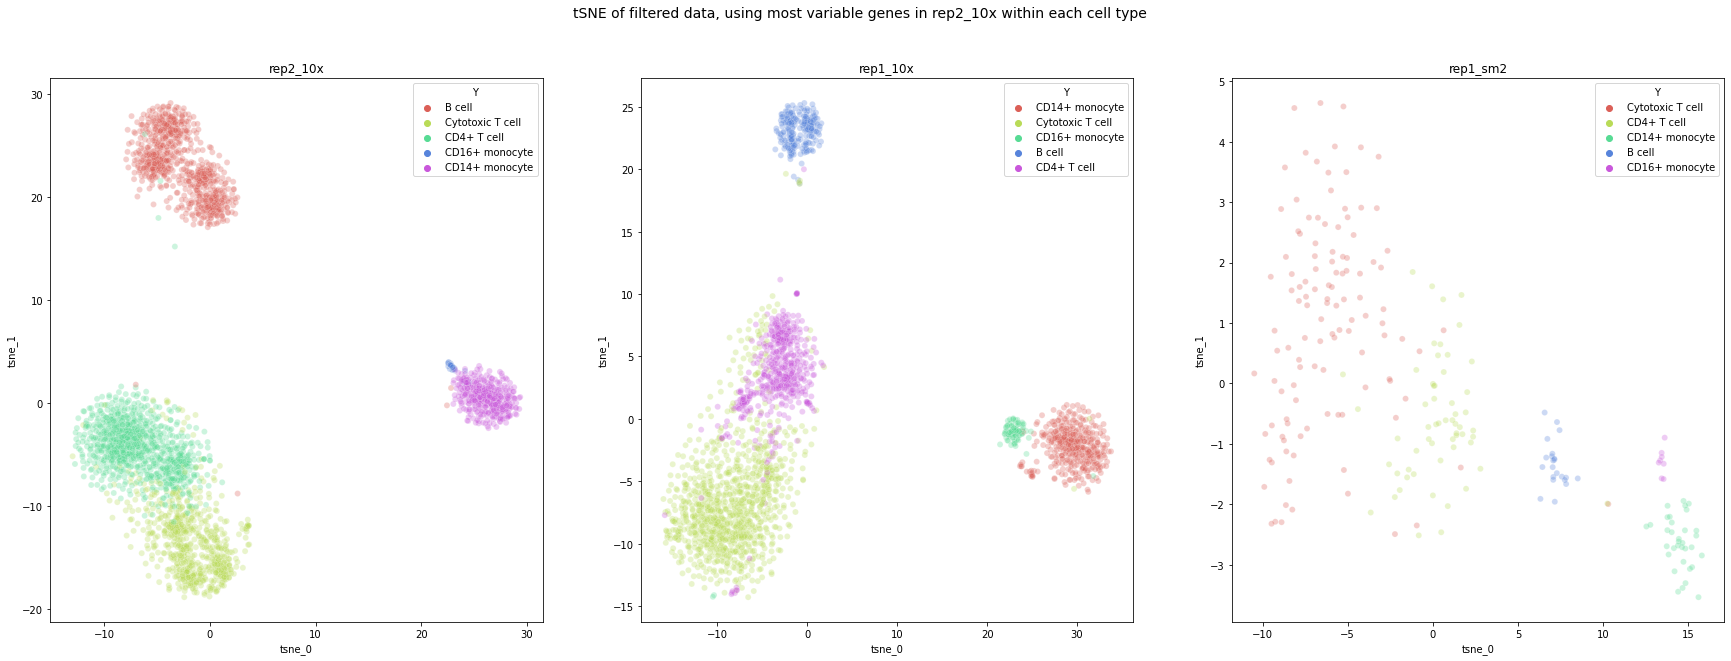

In [8]:
# now lets plot each experiment using the reference genes

def get_tsne_for_plotting(encodings):
    encodings = np.log2(encodings + 1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, init="pca", learning_rate='auto')
        tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g


fig, axs = plt.subplots(1, 3, figsize=(30,10))


rep2_10x_plot_df = get_tsne_for_plotting(np.asarray(rep2_10x_filt[reference_genes]))
plot_tsne(rep2_10x_plot_df, color_vec=rep2_10x_filt['CellType'].tolist(), ax=axs[0], title="rep2_10x")

rep1_10x_plot_df = get_tsne_for_plotting(np.asarray(rep1_10x_filt[np.intersect1d(reference_genes, rep1_10x_genes)]))
plot_tsne(rep1_10x_plot_df, color_vec=rep1_10x_filt['CellType'].tolist(), ax=axs[1], title="rep1_10x")

rep1_sm2_plot_df = get_tsne_for_plotting(np.asarray(rep1_sm2_filt[np.intersect1d(reference_genes, rep1_sm2_genes)]))
plot_tsne(rep1_sm2_plot_df, color_vec=rep1_sm2_filt['CellType'].tolist(), ax=axs[2], title="rep1_sm2")


fig.suptitle("tSNE of filtered data, using most variable genes in rep2_10x within each cell type", fontsize=14)

fig.show()

print(f"rep2_10x num genes: {reference_genes.shape}")
print(f"rep1_10x num genes: {np.intersect1d(reference_genes, rep1_10x_genes).shape}")
print(f"rep1_sm2 num genes: {np.intersect1d(reference_genes, rep1_sm2_genes).shape}")



(3037, 2)
(3037, 2)
(2975, 2)
(2975, 2)
(253, 2)
(253, 2)
rep2_10x num genes: (3350,)
rep1_10x num genes: (3350,)
rep1_sm2 num genes: (3350,)


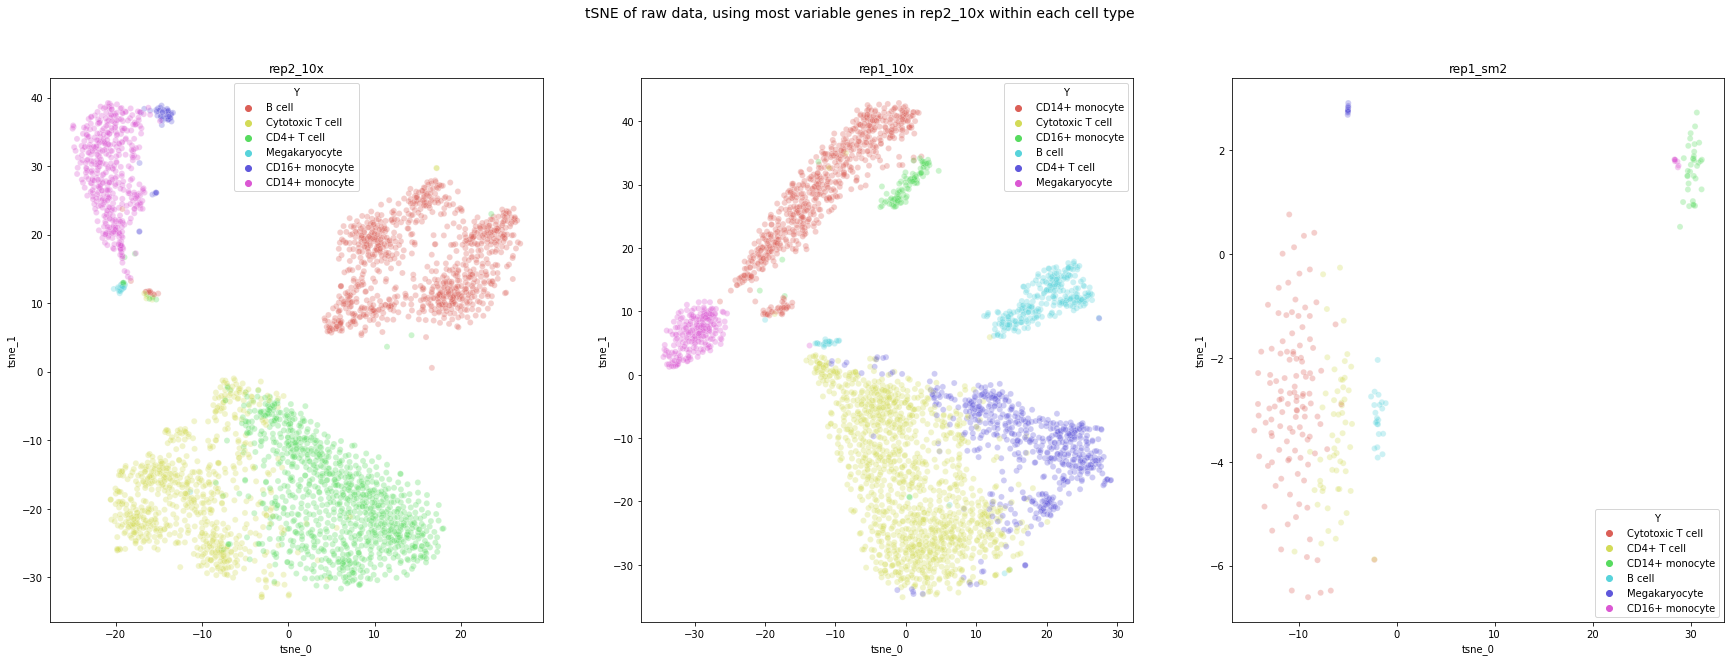

In [9]:


fig, axs = plt.subplots(1, 3, figsize=(30,10))


rep2_10x_plot_df = get_tsne_for_plotting(np.asarray(rep2_10x_expr_df[np.intersect1d(reference_genes, rep2_10x_index_res)]))
plot_tsne(rep2_10x_plot_df, color_vec=rep2_10x_expr_df['CellType'].tolist(), ax=axs[0], title="rep2_10x")

rep1_10x_plot_df = get_tsne_for_plotting(np.asarray(rep1_10x_expr_df[np.intersect1d(reference_genes, rep1_10x_index_res)]))
plot_tsne(rep1_10x_plot_df, color_vec=rep1_10x_expr_df['CellType'].tolist(), ax=axs[1], title="rep1_10x")

rep1_sm2_plot_df = get_tsne_for_plotting(np.asarray(rep1_sm2_expr_df[np.intersect1d(reference_genes, rep1_sm2_index_res)]))
plot_tsne(rep1_sm2_plot_df, color_vec=rep1_sm2_expr_df['CellType'].tolist(), ax=axs[2], title="rep1_sm2")


fig.suptitle("tSNE of raw data, using most variable genes in rep2_10x within each cell type", fontsize=14)

fig.show()

print(f"rep2_10x num genes: {np.intersect1d(reference_genes, rep2_10x_index_res).shape}")
print(f"rep1_10x num genes: {np.intersect1d(reference_genes, rep1_10x_index_res).shape}")
print(f"rep1_sm2 num genes: {np.intersect1d(reference_genes, rep1_sm2_index_res).shape}")


(2891, 2)
(2891, 2)
(2266, 2)
(2266, 2)
(239, 2)
(239, 2)
rep2_10x num genes: (3872,)
rep1_10x num genes: (3175,)
rep1_sm2 num genes: (3766,)


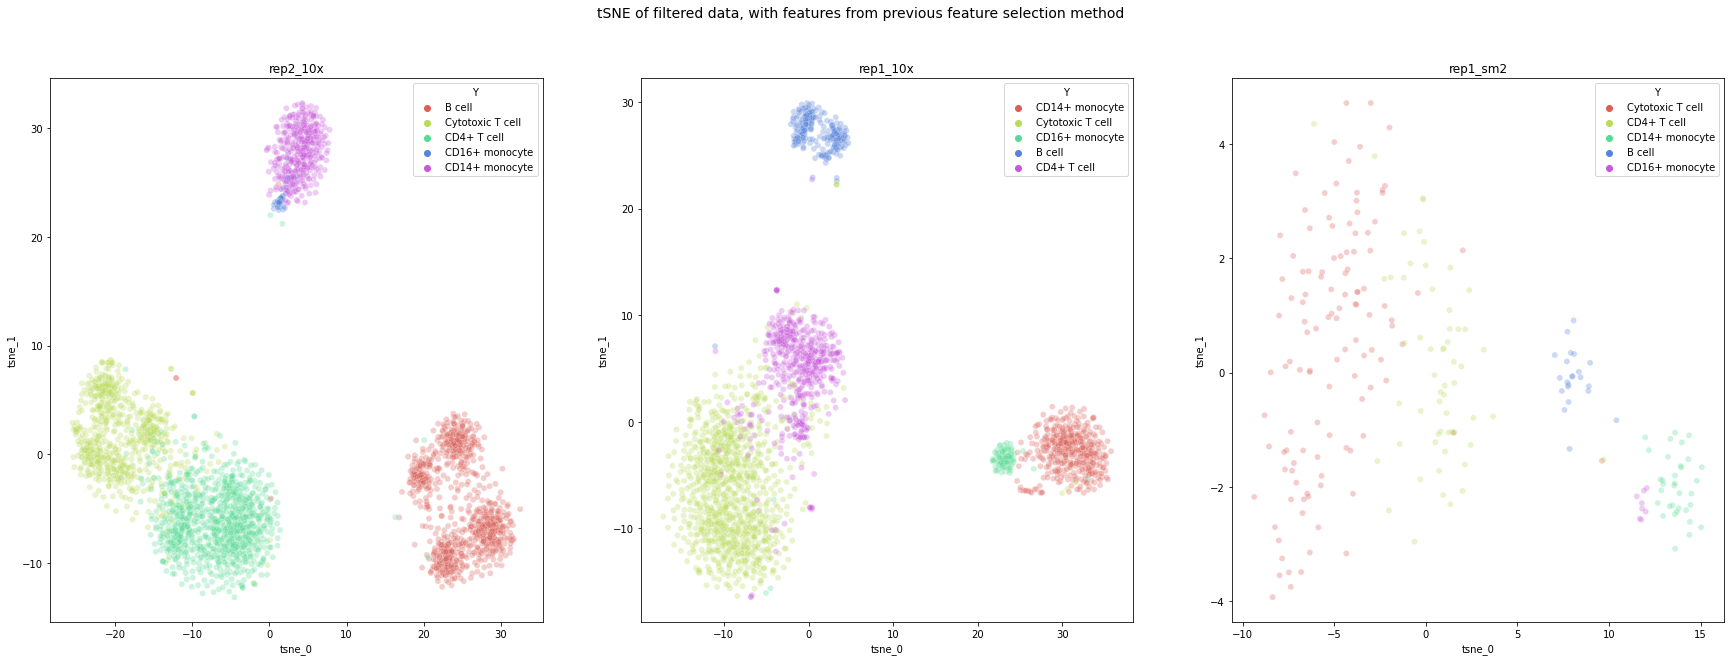

In [10]:
# now how does this compare to the other way we selected the features

old_genes_file = os.path.join(aug_data_path, "intersection_genes.pkl")
gene_out_path = Path(old_genes_file)
old_genes = pickle.load(open( gene_out_path, "rb" ))


fig, axs = plt.subplots(1, 3, figsize=(30,10))


rep2_10x_plot_df = get_tsne_for_plotting(np.asarray(rep2_10x_filt[np.intersect1d(old_genes, common_genes)]))
plot_tsne(rep2_10x_plot_df, color_vec=rep2_10x_filt['CellType'].tolist(), ax=axs[0], title="rep2_10x")

rep1_10x_plot_df = get_tsne_for_plotting(np.asarray(rep1_10x_filt[np.intersect1d(old_genes, common_genes)]))
plot_tsne(rep1_10x_plot_df, color_vec=rep1_10x_filt['CellType'].tolist(), ax=axs[1], title="rep1_10x")

rep1_sm2_plot_df = get_tsne_for_plotting(np.asarray(rep1_sm2_filt[np.intersect1d(old_genes, common_genes)]))
plot_tsne(rep1_sm2_plot_df, color_vec=rep1_sm2_filt['CellType'].tolist(), ax=axs[2], title="rep1_sm2")


fig.suptitle("tSNE of filtered data, with features from previous feature selection method", fontsize=14)

fig.show()

print(f"rep2_10x num genes: {np.intersect1d(old_genes, rep2_10x_genes).shape}")
print(f"rep1_10x num genes: {np.intersect1d(old_genes, rep1_10x_genes).shape}")
print(f"rep1_sm2 num genes: {np.intersect1d(old_genes, rep1_sm2_genes).shape}")



(3037, 2)
(3037, 2)
(2975, 2)
(2975, 2)
(253, 2)
(253, 2)
rep2_10x num genes: (2282,)
rep1_10x num genes: (2282,)
rep1_sm2 num genes: (2282,)


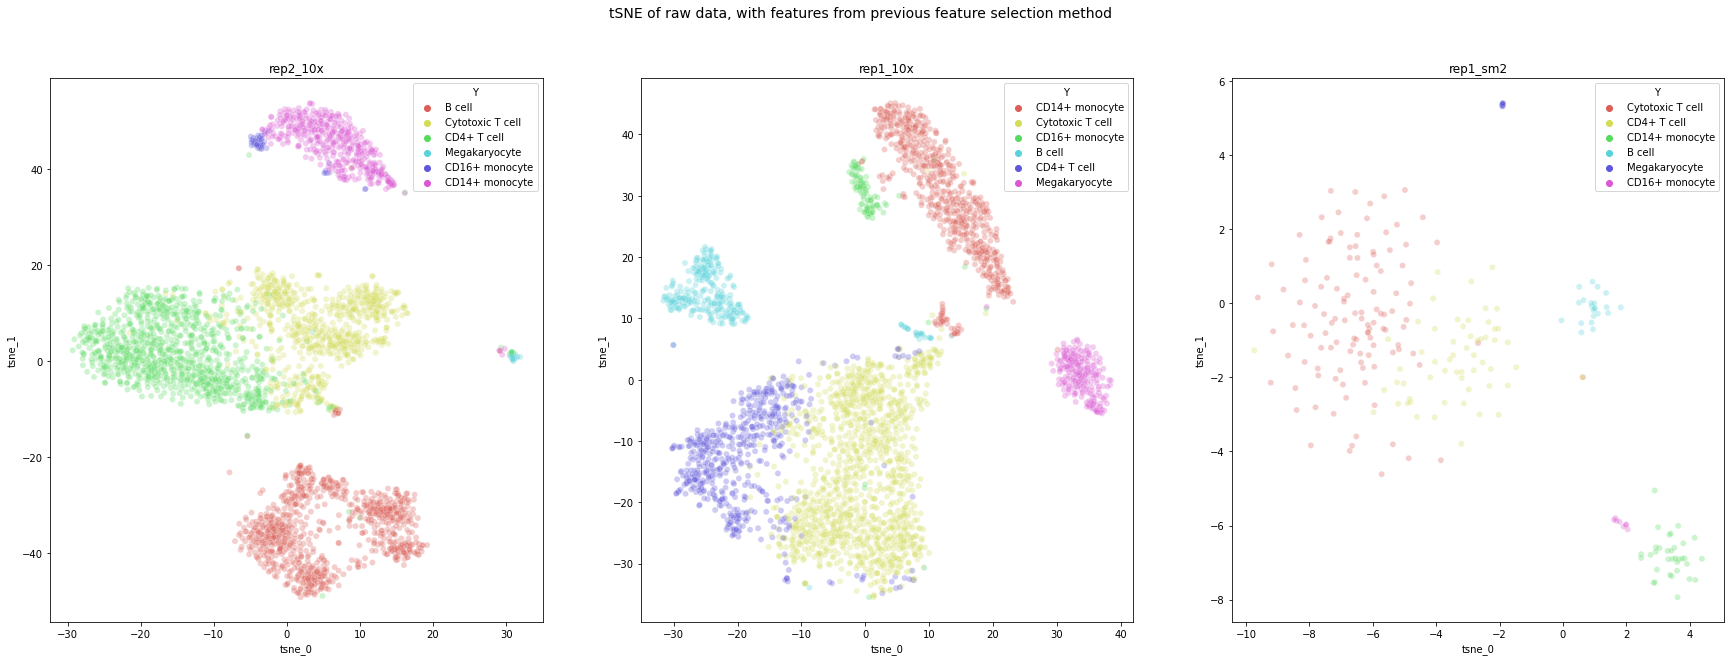

In [11]:


fig, axs = plt.subplots(1, 3, figsize=(30,10))


rep2_10x_plot_df = get_tsne_for_plotting(np.asarray(rep2_10x_expr_df[np.intersect1d(old_genes, common_genes)]))
plot_tsne(rep2_10x_plot_df, color_vec=rep2_10x_expr_df['CellType'].tolist(), ax=axs[0], title="rep2_10x")

rep1_10x_plot_df = get_tsne_for_plotting(np.asarray(rep1_10x_expr_df[np.intersect1d(old_genes, common_genes)]))
plot_tsne(rep1_10x_plot_df, color_vec=rep1_10x_expr_df['CellType'].tolist(), ax=axs[1], title="rep1_10x")

rep1_sm2_plot_df = get_tsne_for_plotting(np.asarray(rep1_sm2_expr_df[np.intersect1d(old_genes, common_genes)]))
plot_tsne(rep1_sm2_plot_df, color_vec=rep1_sm2_expr_df['CellType'].tolist(), ax=axs[2], title="rep1_sm2")


fig.suptitle("tSNE of raw data, with features from previous feature selection method", fontsize=14)

fig.show()

print(f"rep2_10x num genes: {np.intersect1d(old_genes, common_genes).shape}")
print(f"rep1_10x num genes: {np.intersect1d(old_genes, common_genes).shape}")
print(f"rep1_sm2 num genes: {np.intersect1d(old_genes, common_genes).shape}")


KeyError: "['ENSG00000002745_WNT16', 'ENSG00000005471_ABCB4', 'ENSG00000006659_LGALS14', 'ENSG00000007866_TEAD3', 'ENSG00000008382_MPND', 'ENSG00000011143_MKS1', 'ENSG00000013016_EHD3', 'ENSG00000014257_ACPP', 'ENSG00000036565_SLC18A1', 'ENSG00000037280_FLT4', 'ENSG00000039987_BEST2', 'ENSG00000040275_SPDL1', 'ENSG00000043591_ADRB1', 'ENSG00000046889_PREX2', 'ENSG00000062370_ZNF112', 'ENSG00000064205_WISP2', 'ENSG00000065833_ME1', 'ENSG00000068383_INPP5A', 'ENSG00000070371_CLTCL1', 'ENSG00000070404_FSTL3', 'ENSG00000070526_ST6GALNAC1', 'ENSG00000070915_SLC12A3', 'ENSG00000072952_MRVI1', 'ENSG00000073008_PVR', 'ENSG00000073067_CYP2W1', 'ENSG00000076258_FMO4', 'ENSG00000077063_CTTNBP2', 'ENSG00000077152_UBE2T', 'ENSG00000077616_NAALAD2', 'ENSG00000078018_MAP2', 'ENSG00000083857_FAT1', 'ENSG00000087237_CETP', 'ENSG00000088256_GNA11', 'ENSG00000088386_SLC15A1', 'ENSG00000088881_EBF4', 'ENSG00000089356_FXYD3', 'ENSG00000090776_EFNB1', 'ENSG00000091106_NLRC4', 'ENSG00000091622_PITPNM3', 'ENSG00000091972_CD200', 'ENSG00000091986_CCDC80', 'ENSG00000092068_SLC7A8', 'ENSG00000092758_COL9A3', 'ENSG00000099282_TSPAN15', 'ENSG00000099834_CDHR5', 'ENSG00000099840_IZUMO4', 'ENSG00000100012_SEC14L3', 'ENSG00000100288_CHKB', 'ENSG00000100341_PNPLA5', 'ENSG00000100462_PRMT5', 'ENSG00000100767_PAPLN', 'ENSG00000102057_KCND1', 'ENSG00000103056_SMPD3', 'ENSG00000104432_IL7', 'ENSG00000104691_UBXN8', 'ENSG00000105011_ASF1B', 'ENSG00000105889_STEAP1B', 'ENSG00000106484_MEST', 'ENSG00000107719_PALD1', 'ENSG00000108641_B9D1', 'ENSG00000109099_PMP22', 'ENSG00000109501_WFS1', 'ENSG00000109991_P2RX3', 'ENSG00000110042_DTX4', 'ENSG00000110203_FOLR3', 'ENSG00000110455_ACCS', 'ENSG00000111181_SLC6A12', 'ENSG00000111328_CDK2AP1', 'ENSG00000111837_MAK', 'ENSG00000112195_TREML2', 'ENSG00000112210_RAB23', 'ENSG00000112290_WASF1', 'ENSG00000112293_GPLD1', 'ENSG00000112379_ARFGEF3', 'ENSG00000112530_PACRG', 'ENSG00000113296_THBS4', 'ENSG00000113790_EHHADH', 'ENSG00000114853_ZBTB47', 'ENSG00000114948_ADAM23', 'ENSG00000115274_INO80B', 'ENSG00000115318_LOXL3', 'ENSG00000115590_IL1R2', 'ENSG00000115602_IL1RL1', 'ENSG00000116039_ATP6V1B1', 'ENSG00000116690_PRG4', 'ENSG00000116983_HPCAL4', 'ENSG00000117322_CR2', 'ENSG00000118194_TNNT2', 'ENSG00000118432_CNR1', 'ENSG00000118557_PMFBP1', 'ENSG00000119333_WDR34', 'ENSG00000119401_TRIM32', 'ENSG00000119771_KLHL29', 'ENSG00000121053_EPX', 'ENSG00000121594_CD80', 'ENSG00000122025_FLT3', 'ENSG00000122043_LINC00544', 'ENSG00000122126_OCRL', 'ENSG00000122543_OCM', 'ENSG00000123096_SSPN', 'ENSG00000123612_ACVR1C', 'ENSG00000123700_KCNJ2', 'ENSG00000123977_DAW1', 'ENSG00000124074_ENKD1', 'ENSG00000124507_PACSIN1', 'ENSG00000124780_KCNK17', 'ENSG00000125170_DOK4', 'ENSG00000125733_TRIP10', 'ENSG00000126895_AVPR2', 'ENSG00000127580_WDR24', 'ENSG00000128268_MGAT3', 'ENSG00000128596_CCDC136', 'ENSG00000130584_ZBTB46', 'ENSG00000130649_CYP2E1', 'ENSG00000130988_RGN', 'ENSG00000131203_IDO1', 'ENSG00000131470_PSMC3IP', 'ENSG00000131845_ZNF304', 'ENSG00000131969_ABHD12B', 'ENSG00000132010_ZNF20', 'ENSG00000132321_IQCA1', 'ENSG00000132464_ENAM', 'ENSG00000132677_RHBG', 'ENSG00000132744_ACY3', 'ENSG00000132801_ZSWIM3', 'ENSG00000133019_CHRM3', 'ENSG00000133466_C1QTNF6', 'ENSG00000133739_LRRCC1', 'ENSG00000134028_ADAMDEC1', 'ENSG00000134042_MRO', 'ENSG00000134057_CCNB1', 'ENSG00000135144_DTX1', 'ENSG00000135436_FAM186B', 'ENSG00000135480_KRT7', 'ENSG00000135605_TEC', 'ENSG00000135740_SLC9A5', 'ENSG00000135898_GPR55', 'ENSG00000136010_ALDH1L2', 'ENSG00000136929_HEMGN', 'ENSG00000137098_SPAG8', 'ENSG00000137266_SLC22A23', 'ENSG00000137757_CASP5', 'ENSG00000137819_PAQR5', 'ENSG00000137877_SPTBN5', 'ENSG00000137942_FNBP1L', 'ENSG00000138080_EMILIN1', 'ENSG00000138435_CHRNA1', 'ENSG00000138735_PDE5A', 'ENSG00000138769_CDKL2', 'ENSG00000139174_PRICKLE1', 'ENSG00000139880_CDH24', 'ENSG00000139970_RTN1', 'ENSG00000141013_GAS8', 'ENSG00000142552_RCN3', 'ENSG00000143167_GPA33', 'ENSG00000143367_TUFT1', 'ENSG00000143457_GOLPH3L', 'ENSG00000143867_OSR1', 'ENSG00000143869_GDF7', 'ENSG00000144115_THNSL2', 'ENSG00000144771_LRTM1', 'ENSG00000145103_ILDR1', 'ENSG00000145331_TRMT10A', 'ENSG00000145692_BHMT', 'ENSG00000145721_LIX1', 'ENSG00000145945_FAM50B', 'ENSG00000146250_PRSS35', 'ENSG00000146410_MTFR2', 'ENSG00000146839_ZAN', 'ENSG00000147117_ZNF157', 'ENSG00000147180_ZNF711', 'ENSG00000147642_SYBU', 'ENSG00000148468_FAM171A1', 'ENSG00000148832_PAOX', 'ENSG00000149289_ZC3H12C', 'ENSG00000149435_GGTLC1', 'ENSG00000149503_INCENP', 'ENSG00000152672_CLEC4F', 'ENSG00000153165_RGPD3', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154537_FAM27C', 'ENSG00000154928_EPHB1', 'ENSG00000155367_PPM1J', 'ENSG00000155792_DEPTOR', 'ENSG00000155897_ADCY8', 'ENSG00000155974_GRIP1', 'ENSG00000156427_FGF18', 'ENSG00000157992_KRTCAP3', 'ENSG00000158113_LRRC43', 'ENSG00000158445_KCNB1', 'ENSG00000158488_CD1E', 'ENSG00000158714_SLAMF8', 'ENSG00000158865_SLC5A11', 'ENSG00000158887_MPZ', 'ENSG00000159173_TNNI1', 'ENSG00000160221_C21orf33', 'ENSG00000160791_CCR5', 'ENSG00000162004_CCDC78', 'ENSG00000162105_SHANK2', 'ENSG00000162227_TAF6L', 'ENSG00000162373_BEND5', 'ENSG00000162374_ELAVL4', 'ENSG00000162396_PARS2', 'ENSG00000162433_AK4', 'ENSG00000162437_RAVER2', 'ENSG00000162512_SDC3', 'ENSG00000162630_B3GALT2', 'ENSG00000162694_EXTL2', 'ENSG00000162877_PM20D1', 'ENSG00000163006_CCDC138', 'ENSG00000163235_TGFA', 'ENSG00000163283_ALPP', 'ENSG00000163464_CXCR1', 'ENSG00000163482_STK36', 'ENSG00000163528_CHCHD4', 'ENSG00000163606_CD200R1', 'ENSG00000163701_IL17RE', 'ENSG00000163735_CXCL5', 'ENSG00000164011_ZNF691', 'ENSG00000164197_RNF180', 'ENSG00000164236_ANKRD33B', 'ENSG00000164393_ADGRF2', 'ENSG00000164440_TXLNB', 'ENSG00000164484_TMEM200A', 'ENSG00000164520_RAET1E', 'ENSG00000164530_PI16', 'ENSG00000164588_HCN1', 'ENSG00000164619_BMPER', 'ENSG00000164729_SLC35G3', 'ENSG00000164741_DLC1', 'ENSG00000164744_SUN3', 'ENSG00000164877_MICALL2', 'ENSG00000165244_ZNF367', 'ENSG00000165548_TMEM63C', 'ENSG00000165816_VWA2', 'ENSG00000165905_GYLTL1B', 'ENSG00000165972_CCDC38', 'ENSG00000166352_C11orf74', 'ENSG00000166676_TVP23A', 'ENSG00000166831_RBPMS2', 'ENSG00000166928_MS4A14', 'ENSG00000167130_DOLPP1', 'ENSG00000167136_ENDOG', 'ENSG00000167371_PRRT2', 'ENSG00000167619_TMEM145', 'ENSG00000167644_C19orf33', 'ENSG00000167702_KIFC2', 'ENSG00000167920_TMEM99', 'ENSG00000167964_RAB26', 'ENSG00000168268_NT5DC2', 'ENSG00000168309_FAM107A', 'ENSG00000168427_KLHL30', 'ENSG00000168477_TNXB', 'ENSG00000168970_JMJD7-PLA2G4B', 'ENSG00000169047_IRS1', 'ENSG00000169071_ROR2', 'ENSG00000169851_PCDH7', 'ENSG00000169884_WNT10B', 'ENSG00000170899_GSTA4', 'ENSG00000171119_NRTN', 'ENSG00000171357_LURAP1', 'ENSG00000171435_KSR2', 'ENSG00000172014_ANKRD20A4', 'ENSG00000172889_EGFL7', 'ENSG00000173077_DEC1', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173535_TNFRSF10C', 'ENSG00000173567_ADGRF3', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174327_SLC16A13', 'ENSG00000174405_LIG4', 'ENSG00000174469_CNTNAP2', 'ENSG00000174529_TMEM81', 'ENSG00000174885_NLRP6', 'ENSG00000175164_ABO', 'ENSG00000175536_LIPT2', 'ENSG00000175604_RP11-276H1.3', 'ENSG00000175643_RMI2', 'ENSG00000175691_ZNF77', 'ENSG00000176160_HSF5', 'ENSG00000176222_ZNF404', 'ENSG00000176349_AC110781.3', 'ENSG00000176472_ZNF575', 'ENSG00000176788_BASP1', 'ENSG00000177096_FAM109B', 'ENSG00000177103_DSCAML1', 'ENSG00000177108_ZDHHC22', 'ENSG00000177599_ZNF491', 'ENSG00000177732_SOX12', 'ENSG00000177943_MAMDC4', 'ENSG00000177946_CENPBD1', 'ENSG00000178038_ALS2CL', 'ENSG00000178409_BEND3', 'ENSG00000178814_OPLAH', 'ENSG00000178928_TPRX1', 'ENSG00000179057_IGSF22', 'ENSG00000179520_SLC17A8', 'ENSG00000180116_C12orf40', 'ENSG00000180346_TIGD2', 'ENSG00000180525_PRR26', 'ENSG00000180549_FUT7', 'ENSG00000180574_EIF2S3L', 'ENSG00000180938_ZNF572', 'ENSG00000181751_C5orf30', 'ENSG00000181800_CELF2-AS1', 'ENSG00000181885_CLDN7', 'ENSG00000181915_ADO', 'ENSG00000182107_TMEM30B', 'ENSG00000182253_SYNM', 'ENSG00000182580_EPHB3', 'ENSG00000182809_CRIP2', 'ENSG00000182853_VMO1', 'ENSG00000183018_SPNS2', 'ENSG00000183048_SLC25A10', 'ENSG00000183134_PTGDR2', 'ENSG00000183347_GBP6', 'ENSG00000183479_TREX2', 'ENSG00000183662_FAM19A1', 'ENSG00000183690_EFHC2', 'ENSG00000183814_LIN9', 'ENSG00000183960_KCNH8', 'ENSG00000183977_PP2D1', 'ENSG00000184357_HIST1H1B', 'ENSG00000184619_KRBA2', 'ENSG00000184647_PRSS55', 'ENSG00000184867_ARMCX2', 'ENSG00000185010_F8', 'ENSG00000185453_C19orf68', 'ENSG00000185483_ROR1', 'ENSG00000185736_ADARB2', 'ENSG00000185739_SRL', 'ENSG00000185837_CECR5-AS1', 'ENSG00000186369_LINC00643', 'ENSG00000186564_FOXD2', 'ENSG00000186792_HYAL3', 'ENSG00000186825_C2orf27B', 'ENSG00000186919_ZACN', 'ENSG00000187033_SAMD7', 'ENSG00000187474_FPR3', 'ENSG00000187510_PLEKHG7', 'ENSG00000187626_ZKSCAN4', 'ENSG00000187871_GFRAL', 'ENSG00000188452_CERKL', 'ENSG00000188886_ASTL', 'ENSG00000189238_LINC00943', 'ENSG00000189401_OTUD6A', 'ENSG00000196152_ZNF79', 'ENSG00000196167_COLCA1', 'ENSG00000196361_ELAVL3', 'ENSG00000196421_LINC00176', 'ENSG00000196535_MYO18A', 'ENSG00000196549_MME', 'ENSG00000196557_CACNA1H', 'ENSG00000196689_TRPV1', 'ENSG00000196724_ZNF418', 'ENSG00000196741_LINC01560', 'ENSG00000196867_ZFP28', 'ENSG00000197128_ZNF772', 'ENSG00000197238_HIST1H4J', 'ENSG00000197275_RAD54B', 'ENSG00000197353_LYPD2', 'ENSG00000197461_PDGFA', 'ENSG00000197520_FAM177B', 'ENSG00000197558_SSPO', 'ENSG00000197646_PDCD1LG2', 'ENSG00000197647_ZNF433', 'ENSG00000197721_CR1L', 'ENSG00000197980_LEKR1', 'ENSG00000198018_ENTPD7', 'ENSG00000198298_ZNF485', 'ENSG00000198711_SSBP3-AS1', 'ENSG00000198822_GRM3', 'ENSG00000198924_DCLRE1A', 'ENSG00000203867_RBM20', 'ENSG00000204388_HSPA1B', 'ENSG00000204390_HSPA1L', 'ENSG00000204580_DDR1', 'ENSG00000204792_LINC01291', 'ENSG00000204814_RP11-160N1.10', 'ENSG00000204860_FAM201A', 'ENSG00000205038_PKHD1L1', 'ENSG00000205213_LGR4', 'ENSG00000206344_HCG27', 'ENSG00000206535_LNP1', 'ENSG00000211598_IGKV4-1', 'ENSG00000211640_IGLV6-57', 'ENSG00000211648_IGLV1-47', 'ENSG00000211651_IGLV1-44', 'ENSG00000211653_IGLV1-40', 'ENSG00000211659_IGLV3-25', 'ENSG00000211663_IGLV3-19', 'ENSG00000211668_IGLV2-11', 'ENSG00000211669_IGLV3-10', 'ENSG00000211673_IGLV3-1', 'ENSG00000211714_TRBV7-3', 'ENSG00000211734_TRBV5-1', 'ENSG00000211747_TRBV20-1', 'ENSG00000211750_TRBV24-1', 'ENSG00000211787_TRAV8-3', 'ENSG00000211789_TRAV12-2', 'ENSG00000211793_TRAV9-2', 'ENSG00000211807_TRAV26-1', 'ENSG00000211810_TRAV29DV5', 'ENSG00000211837_TRAJ53', 'ENSG00000211892_IGHG4', 'ENSG00000211893_IGHG2', 'ENSG00000211938_IGHV3-7', 'ENSG00000211943_IGHV3-15', 'ENSG00000211949_IGHV3-23', 'ENSG00000211950_IGHV1-24', 'ENSG00000211962_IGHV1-46', 'ENSG00000211965_IGHV3-49', 'ENSG00000211966_IGHV5-51', 'ENSG00000211976_IGHV3-73', 'ENSG00000212747_FAM127C', 'ENSG00000213171_LINGO4', 'ENSG00000213279_RP1-29C18.9', 'ENSG00000213366_GSTM2', 'ENSG00000214140_PRCD', 'ENSG00000214293_APTR', 'ENSG00000214708_AC090616.2', 'ENSG00000214711_CAPN14', 'ENSG00000214787_MS4A4E', 'ENSG00000221818_EBF2', 'ENSG00000222044_RP5-1039K5.16', 'ENSG00000223534_HLA-DQB1-AS1', 'ENSG00000223725_AC007879.5', 'ENSG00000223901_AP001469.5', 'ENSG00000224157_HCG14', 'ENSG00000224307_RP11-344B5.2', 'ENSG00000224610_RP11-265P11.1', 'ENSG00000224650_IGHV3-74', 'ENSG00000225077_LINC00337', 'ENSG00000225234_TRAPPC12-AS1', 'ENSG00000225377_NRSN2-AS1', 'ENSG00000225434_LINC01504', 'ENSG00000225450_RP3-508I15.14', 'ENSG00000225527_RP11-383B4.4', 'ENSG00000225595_LINC01623', 'ENSG00000225614_ZNF469', 'ENSG00000225721_RP11-269F19.2', 'ENSG00000226174_TEX22', 'ENSG00000226180_RP11-278A23.1', 'ENSG00000226472_RP11-551L14.4', 'ENSG00000226686_LINC01535', 'ENSG00000226715_RP11-411H5.1', 'ENSG00000226763_SRRM5', 'ENSG00000226889_RP11-474I16.8', 'ENSG00000227014_AC007285.6', 'ENSG00000227070_RP11-191G24.1', 'ENSG00000227155_RP11-165F24.3', 'ENSG00000227540_RP11-152N13.5', 'ENSG00000227603_RP11-165J3.6', 'ENSG00000227673_RP11-243J18.2', 'ENSG00000227733_RP4-565E6.1', 'ENSG00000227920_RP1-153P14.5', 'ENSG00000228058_RP11-552D4.1', 'ENSG00000228274_RP3-508I15.9', 'ENSG00000228543_GS1-519E5.1', 'ENSG00000228624_RP3-399L15.3', 'ENSG00000228655_AC096558.1', 'ENSG00000228701_TNKS2-AS1', 'ENSG00000228817_BACH1-IT2', 'ENSG00000228852_RP11-57H12.5', 'ENSG00000228878_SEPT7-AS1', 'ENSG00000229056_AC020571.3', 'ENSG00000229105_ASTN2-AS1', 'ENSG00000229591_RP5-981O7.2', 'ENSG00000229807_XIST', 'ENSG00000230322_RP3-323N1.2', 'ENSG00000230561_LINC01183', 'ENSG00000231310_TBL1XR1-AS1', 'ENSG00000231680_AP003774.6', 'ENSG00000231728_LL0XNC01-116E7.2', 'ENSG00000231789_PIK3CD-AS2', 'ENSG00000231794_AC009542.2', 'ENSG00000232353_RP11-655G22.1', 'ENSG00000232504_ST3GAL5-AS1', 'ENSG00000232725_U52111.14', 'ENSG00000232855_AF131217.1', 'ENSG00000232995_RGS5', 'ENSG00000233108_AC006042.7', 'ENSG00000233178_RP11-88I18.2', 'ENSG00000233255_AC019181.2', 'ENSG00000234006_DDX39B-AS1', 'ENSG00000234015_RP11-125M16.1', 'ENSG00000234284_ZNF879', 'ENSG00000234423_LINC01250', 'ENSG00000234478_RP11-275I14.4', 'ENSG00000234859_AC003958.2', 'ENSG00000234928_AP000344.3', 'ENSG00000234962_LINC00700', 'ENSG00000235052_RP1-150O5.3', 'ENSG00000235079_ZRANB2-AS1', 'ENSG00000235245_RP11-122K13.12', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000236432_AC097662.2', 'ENSG00000236859_NIFK-AS1', 'ENSG00000236990_RP11-433J20.1', 'ENSG00000237111_IGHJ3P', 'ENSG00000237172_B3GNT9', 'ENSG00000237292_RP11-540K16.1', 'ENSG00000237301_RP4-680D5.2', 'ENSG00000237923_XXbac-BPG27H4.8', 'ENSG00000238260_RP11-46F15.2', 'ENSG00000238273_AC012360.6', 'ENSG00000239523_MYLK-AS1', 'ENSG00000239642_MEIKIN', 'ENSG00000239951_IGKV3-20', 'ENSG00000240063_RP11-225N10.1', 'ENSG00000240710_RP11-430C7.4', 'ENSG00000241043_GVQW1', 'ENSG00000241351_IGKV3-11', 'ENSG00000242110_AMACR', 'ENSG00000242265_PEG10', 'ENSG00000242622_RP11-18H7.1', 'ENSG00000243224_RP5-1157M23.2', 'ENSG00000243466_IGKV1-5', 'ENSG00000243629_LINC00880', 'ENSG00000244184_RP11-314A20.2', 'ENSG00000244607_CCDC13', 'ENSG00000245870_LINC00682', 'ENSG00000245888_FLJ21408', 'ENSG00000245954_RP11-18H21.1', 'ENSG00000246877_DNM1P35', 'ENSG00000248839_RP11-227H4.5', 'ENSG00000249087_ZNF436-AS1', 'ENSG00000249267_LINC00939', 'ENSG00000249835_VCAN-AS1', 'ENSG00000250098_RP11-22A3.1', 'ENSG00000250155_CTD-2353F22.1', 'ENSG00000250486_FAM218A', 'ENSG00000250490_FLJ33360', 'ENSG00000250548_RP11-47I22.2', 'ENSG00000250596_RP11-440I14.2', 'ENSG00000250889_LINC01336', 'ENSG00000251015_SLC25A30-AS1', 'ENSG00000251408_RP11-586D19.2', 'ENSG00000251450_RASGRF2-AS1', 'ENSG00000253282_KB-1410C5.3', 'ENSG00000253327_RAD21-AS1', 'ENSG00000253692_IGHEP1', 'ENSG00000253706_RP11-758M4.4', 'ENSG00000253715_RP11-706C16.8', 'ENSG00000253754_RP11-35G22.1', 'ENSG00000253755_IGHGP', 'ENSG00000253811_CTD-2363C16.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000253880_RP11-124B13.1', 'ENSG00000253967_RP11-333A23.4', 'ENSG00000254017_IGHEP2', 'ENSG00000254028_AC083843.2', 'ENSG00000254206_NPIPB11', 'ENSG00000254473_RP11-522I20.3', 'ENSG00000254662_RP11-872D17.4', 'ENSG00000254709_IGLL5', 'ENSG00000254777_AC022182.1', 'ENSG00000255045_RP11-677M14.2', 'ENSG00000255089_RP11-326C3.10', 'ENSG00000255151_GLYATL1P3', 'ENSG00000255337_RP11-315O6.1', 'ENSG00000255389_C6orf3', 'ENSG00000255833_TIFAB', 'ENSG00000256806_C17orf100', 'ENSG00000256955_RP11-417L19.2', 'ENSG00000257239_RP11-630C16.2', 'ENSG00000257252_RP11-486A14.2', 'ENSG00000257345_RP11-511B23.1', 'ENSG00000257433_RP1-197B17.3', 'ENSG00000257704_INAFM1', 'ENSG00000257949_TEN1', 'ENSG00000258086_RP11-753H16.5', 'ENSG00000258119_RP11-804F13.1', 'ENSG00000258227_CLEC5A', 'ENSG00000258424_RP11-471B22.2', 'ENSG00000258478_RP11-232C2.1', 'ENSG00000258659_TRIM34', 'ENSG00000258701_LINC00638', 'ENSG00000258766_DIO2-AS1', 'ENSG00000258792_RP11-944C7.1', 'ENSG00000258810_RP11-219E7.1', 'ENSG00000258831_RP11-76E17.4', 'ENSG00000258843_RP11-286O18.1', 'ENSG00000258940_RP11-407N17.5', 'ENSG00000259004_RP11-8L8.2', 'ENSG00000259038_CTD-2325P2.4', 'ENSG00000259153_RP6-65G23.3', 'ENSG00000259177_RP11-154B12.3', 'ENSG00000259215_RP11-253M7.4', 'ENSG00000259337_IGHV1OR15-2', 'ENSG00000259370_RP11-1069G10.1', 'ENSG00000259417_LINC01314', 'ENSG00000259438_CTD-2650P22.1', 'ENSG00000259577_RP11-430B1.2', 'ENSG00000259583_RP11-66B24.4', 'ENSG00000259615_RP11-429B14.3', 'ENSG00000259768_RP5-991G20.1', 'ENSG00000260000_RP3-467N11.1', 'ENSG00000260188_CTA-331P3.1', 'ENSG00000260317_RP11-48B3.4', 'ENSG00000260526_RP11-73K9.2', 'ENSG00000260698_RP11-439E19.9', 'ENSG00000260886_TAT-AS1', 'ENSG00000260907_AC008088.4', 'ENSG00000261082_LINC01228', 'ENSG00000261087_KB-1460A1.5', 'ENSG00000261104_RP11-734K21.5', 'ENSG00000261141_RP11-303E16.5', 'ENSG00000261172_RP11-356C4.5', 'ENSG00000261235_RP11-510J16.5', 'ENSG00000261359_PYCARD-AS1', 'ENSG00000261448_CTD-2576D5.4', 'ENSG00000261685_RP11-401P9.4', 'ENSG00000261770_CTC-459F4.1', 'ENSG00000261826_RP11-691G17.1', 'ENSG00000262292_RP11-160E2.11', 'ENSG00000263063_RP11-388C12.1', 'ENSG00000263603_CTD-2349P21.5', 'ENSG00000263657_RP11-82O19.1', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264235_RP13-270P17.1', 'ENSG00000264254_CTD-3096M3.1', 'ENSG00000264735_RP11-498C9.17', 'ENSG00000264745_TTC39C-AS1', 'ENSG00000264829_RP11-474I11.8', 'ENSG00000265749_RP11-849F2.5', 'ENSG00000265845_RP11-20B24.5', 'ENSG00000265975_CTB-41I6.2', 'ENSG00000265987_RP11-16C1.3', 'ENSG00000266088_RP5-1028K7.2', 'ENSG00000266111_RP11-296K13.4', 'ENSG00000266654_RP11-1376P16.1', 'ENSG00000266821_RP11-6N17.2', 'ENSG00000267044_AC005757.6', 'ENSG00000267064_UXT-AS1', 'ENSG00000267288_RP13-890H12.2', 'ENSG00000267322_SNHG22', 'ENSG00000267353_CTD-2162K18.3', 'ENSG00000267452_RP11-1018N14.5', 'ENSG00000267547_RP11-686D22.4', 'ENSG00000267673_FDX1L', 'ENSG00000267787_RP11-35G9.5', 'ENSG00000267838_AC008746.12', 'ENSG00000268129_RP11-91G21.1', 'ENSG00000268204_CTD-3214H19.6', 'ENSG00000268364_SMC5-AS1', 'ENSG00000268471_DKFZP434I0714', 'ENSG00000268472_RP11-356J5.13', 'ENSG00000269051_CTD-2245F17.3', 'ENSG00000269072_CTD-3187F8.14', 'ENSG00000269194_AC006942.4', 'ENSG00000269210_RP11-173C1.1', 'ENSG00000269246_CTC-246B18.10', 'ENSG00000269549_RP3-461P17.10', 'ENSG00000269814_CTC-273B12.10', 'ENSG00000270006_RP11-178L8.7', 'ENSG00000270028_RP11-380L11.4', 'ENSG00000270066_SCARNA2', 'ENSG00000270067_CTC-487M23.5', 'ENSG00000270104_RP11-245P10.6', 'ENSG00000270164_LINC01480', 'ENSG00000270177_CTD-2410N18.3', 'ENSG00000270194_RP11-259K5.2', 'ENSG00000270195_RP11-572O17.1', 'ENSG00000270589_RP11-348N5.7', 'ENSG00000270696_RP11-342K6.1', 'ENSG00000270823_RP11-2E11.6', 'ENSG00000270996_RP11-342K6.4', 'ENSG00000271009_RP11-346C20.3', 'ENSG00000271155_RP11-435O5.5', 'ENSG00000271270_TMCC1-AS1', 'ENSG00000271828_CTD-2310F14.1', 'ENSG00000271862_RP11-343L5.2', 'ENSG00000271931_RP11-63L7.5', 'ENSG00000271971_CTD-2006H14.2', 'ENSG00000272004_RP11-345P4.10', 'ENSG00000272172_RP13-582O9.7', 'ENSG00000272264_RP11-92K15.3', 'ENSG00000272305_RP11-894J14.5', 'ENSG00000272374_RP3-329A5.8', 'ENSG00000272382_CTD-2035E11.4', 'ENSG00000272406_RP11-185E12.2', 'ENSG00000272426_RP11-108M9.6', 'ENSG00000272463_RP11-532F6.3', 'ENSG00000272579_RP11-101E13.5', 'ENSG00000272717_RP11-342I1.2', 'ENSG00000272720_CTA-228A9.3', 'ENSG00000272763_RP11-357H14.17', 'ENSG00000272768_RP4-673M15.1', 'ENSG00000272825_LL21NC02-1C16.2', 'ENSG00000272844_RP11-484K9.4', 'ENSG00000272902_RP11-299H21.1', 'ENSG00000273026_RP11-422P24.10', 'ENSG00000273064_RP11-474G23.3', 'ENSG00000273108_RP11-416N2.4', 'ENSG00000273203_AC006946.16', 'ENSG00000273230_RP11-1246C19.1', 'ENSG00000273249_LL09NC01-251B2.3', 'ENSG00000273355_RP11-672L10.6', 'ENSG00000273389_RP13-514E23.2', 'ENSG00000273464_RP11-313P22.1', 'ENSG00000273521_RP11-45A17.4', 'ENSG00000273891_RP11-500G22.5', 'ENSG00000274387_RP11-154H23.5', 'ENSG00000274776_RP11-687F6.5', 'ENSG00000275111_ZNF2', 'ENSG00000275139_RP1-101D8.1', 'ENSG00000275216_RP11-54H7.4', 'ENSG00000275234_CTD-2396E7.11', 'ENSG00000275418_RP11-126O1.6', 'ENSG00000275481_RP11-474P2.6', 'ENSG00000275542_RP11-455O6.9', 'ENSG00000275632_RP5-967N21.11', 'ENSG00000276075_CTD-2012K14.8', 'ENSG00000276131_RP11-481J2.3', 'ENSG00000276449_AC004076.5', 'ENSG00000276529_AP001505.10', 'ENSG00000276718_RP1-102E24.10', 'ENSG00000277128_RP11-146E13.4', 'ENSG00000277232_GTSE1-AS1', 'ENSG00000277496_RP11-93B14.9', 'ENSG00000277701_RP11-734K23.9', 'ENSG00000278017_RP11-120K19.4', 'ENSG00000278196_IGLV2-8', 'ENSG00000278463_HIST1H2AB', 'ENSG00000278619_MRM1', 'ENSG00000278705_HIST1H4B', 'ENSG00000278811_LINC00624', 'ENSG00000279471_AC008759.1', 'ENSG00000279873_LINC01126', 'ENSG00000280441_CH507-528H12.1', 'ENSG00000280544_AC107081.1', 'ENSG00000281181_CH507-513H4.3', 'ENSG00000281404_LINC01176', 'ENSG00000281527_AC087350.1', 'ENSG00000281550_RP11-294C11.5', 'ENSG00000282034_RP11-2C24.9', 'ENSG00000282772_RP11-753C18.12'] not in index"

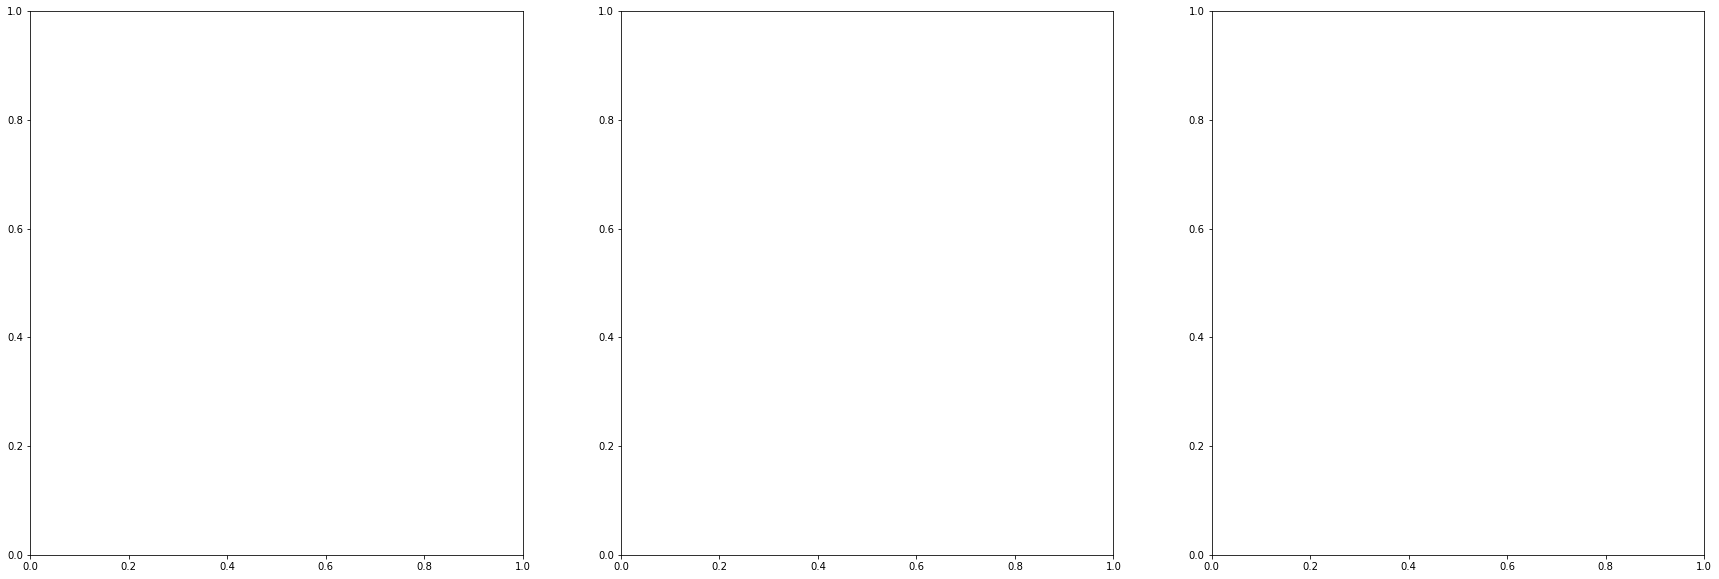

In [13]:
# now what if we chose the representative genes from the pseudobulk

# first read in the pseudobulk
X_sm2, Y_sm2, sm2_gene_df, _ = sc_preprocess.read_diva_files(aug_data_path, 0, 'pbmc_rep2_sm2')

bulk_genes, X_CoV = get_variable_genes_bulk(sm2_gene_df['gene_ids'], 10000, X_sm2)

fig, axs = plt.subplots(1, 3, figsize=(30,10))


rep2_10x_plot_df = get_tsne_for_plotting(np.asarray(rep2_10x_filt[np.intersect1d(bulk_genes, rep2_10x_genes)]))
plot_tsne(rep2_10x_plot_df, color_vec=rep2_10x_filt['CellType'].tolist(), ax=axs[0], title="rep2_10x")

rep1_10x_plot_df = get_tsne_for_plotting(np.asarray(rep1_10x_filt[np.intersect1d(bulk_genes, rep1_10x_genes)]))
plot_tsne(rep1_10x_plot_df, color_vec=rep1_10x_filt['CellType'].tolist(), ax=axs[1], title="rep1_10x")

rep1_sm2_plot_df = get_tsne_for_plotting(np.asarray(rep1_sm2_filt[np.intersect1d(bulk_genes, rep1_sm2_genes)]))
plot_tsne(rep1_sm2_plot_df, color_vec=rep1_sm2_filt['CellType'].tolist(), ax=axs[2], title="rep1_sm2")


fig.suptitle("tSNE of filtered data on rep2_10x bulk chosen genes", fontsize=14)

fig.show()

print(f"rep2_10x num genes: {np.intersect1d(bulk_genes, common_genes).shape}")
print(f"rep1_10x num genes: {np.intersect1d(bulk_genes, common_genes).shape}")
print(f"rep1_sm2 num genes: {np.intersect1d(bulk_genes, common_genes).shape}")



In [ ]:
bulk_genes, X_CoV = get_variable_genes_bulk(sm2_gene_df['gene_ids'], 5000, X_sm2)
np.sort(X_CoV)
print(f"{np.nanmean(X_CoV)} {np.nanmedian(X_CoV)} {np.nanstd(X_CoV)}")

1629.3223295097173 111.1544798203295 21783.95751228765


/tmp/ipykernel_21126/3510417191.py:144: RuntimeWarning: invalid value encountered in true_divide
  X_CoV = np.array(np.divide(X_colvar, X_colmean))


(3037, 2)
(3037, 2)
(2975, 2)
(2975, 2)
(253, 2)
(253, 2)
rep2_10x num genes: (8160,)
rep1_10x num genes: (8160,)
rep1_sm2 num genes: (8160,)


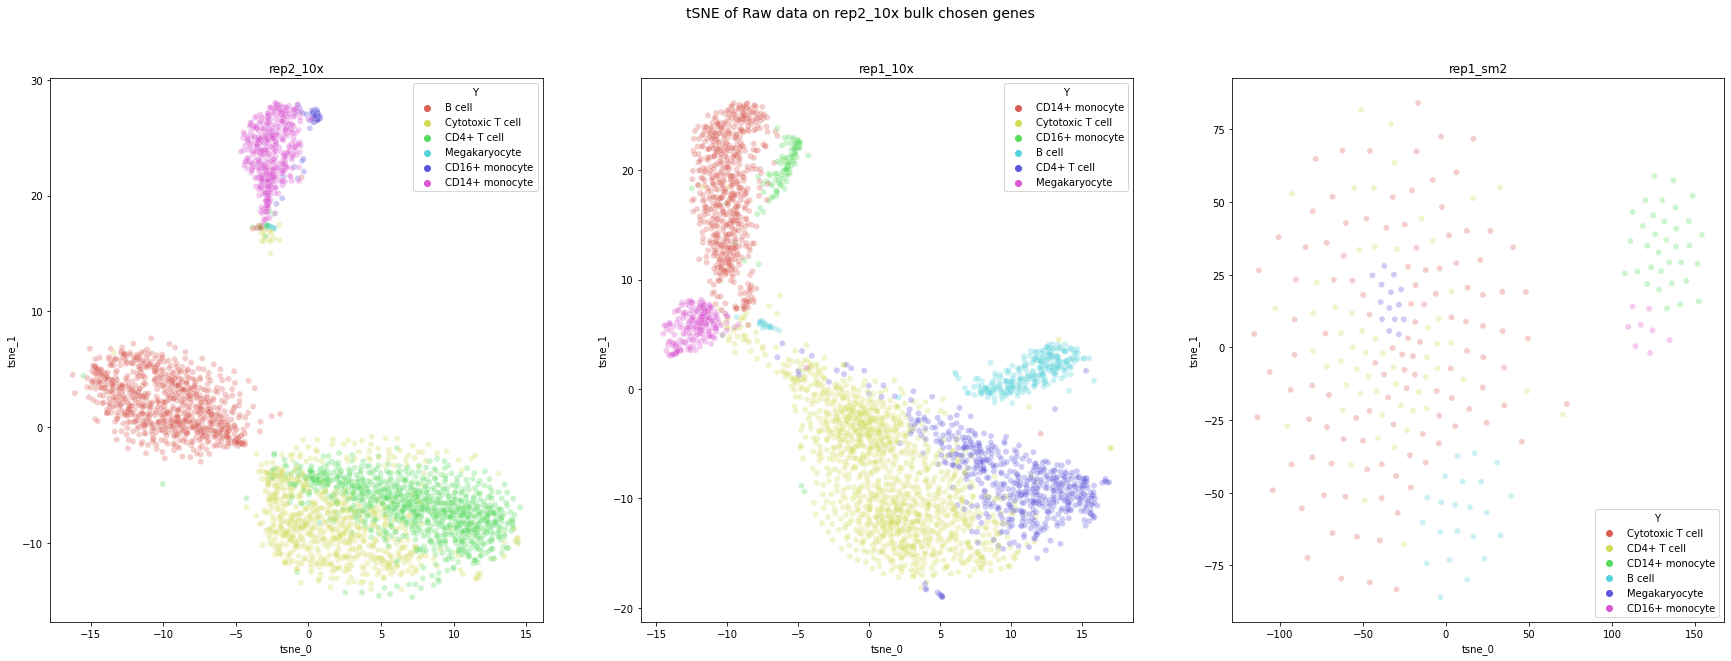

In [14]:



fig, axs = plt.subplots(1, 3, figsize=(30,10))


rep2_10x_plot_df = get_tsne_for_plotting(np.asarray(rep2_10x_expr_df[np.intersect1d(bulk_genes, common_genes)]))
plot_tsne(rep2_10x_plot_df, color_vec=rep2_10x_expr_df['CellType'].tolist(), ax=axs[0], title="rep2_10x")

rep1_10x_plot_df = get_tsne_for_plotting(np.asarray(rep1_10x_expr_df[np.intersect1d(bulk_genes, common_genes)]))
plot_tsne(rep1_10x_plot_df, color_vec=rep1_10x_expr_df['CellType'].tolist(), ax=axs[1], title="rep1_10x")

rep1_sm2_plot_df = get_tsne_for_plotting(np.asarray(rep1_sm2_expr_df[np.intersect1d(bulk_genes, common_genes)]))
plot_tsne(rep1_sm2_plot_df, color_vec=rep1_sm2_expr_df['CellType'].tolist(), ax=axs[2], title="rep1_sm2")


fig.suptitle("tSNE of Raw data on rep2_10x bulk chosen genes", fontsize=14)

fig.show()

print(f"rep2_10x num genes: {np.intersect1d(bulk_genes, common_genes).shape}")
print(f"rep1_10x num genes: {np.intersect1d(bulk_genes, common_genes).shape}")
print(f"rep1_sm2 num genes: {np.intersect1d(bulk_genes, common_genes).shape}")


(2891, 2)
(2891, 2)
(2266, 2)
(2266, 2)
(239, 2)
(239, 2)
rep2_10x num genes: (10084,)
rep1_10x num genes: (10084,)
rep1_sm2 num genes: (10084,)


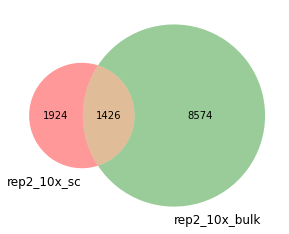

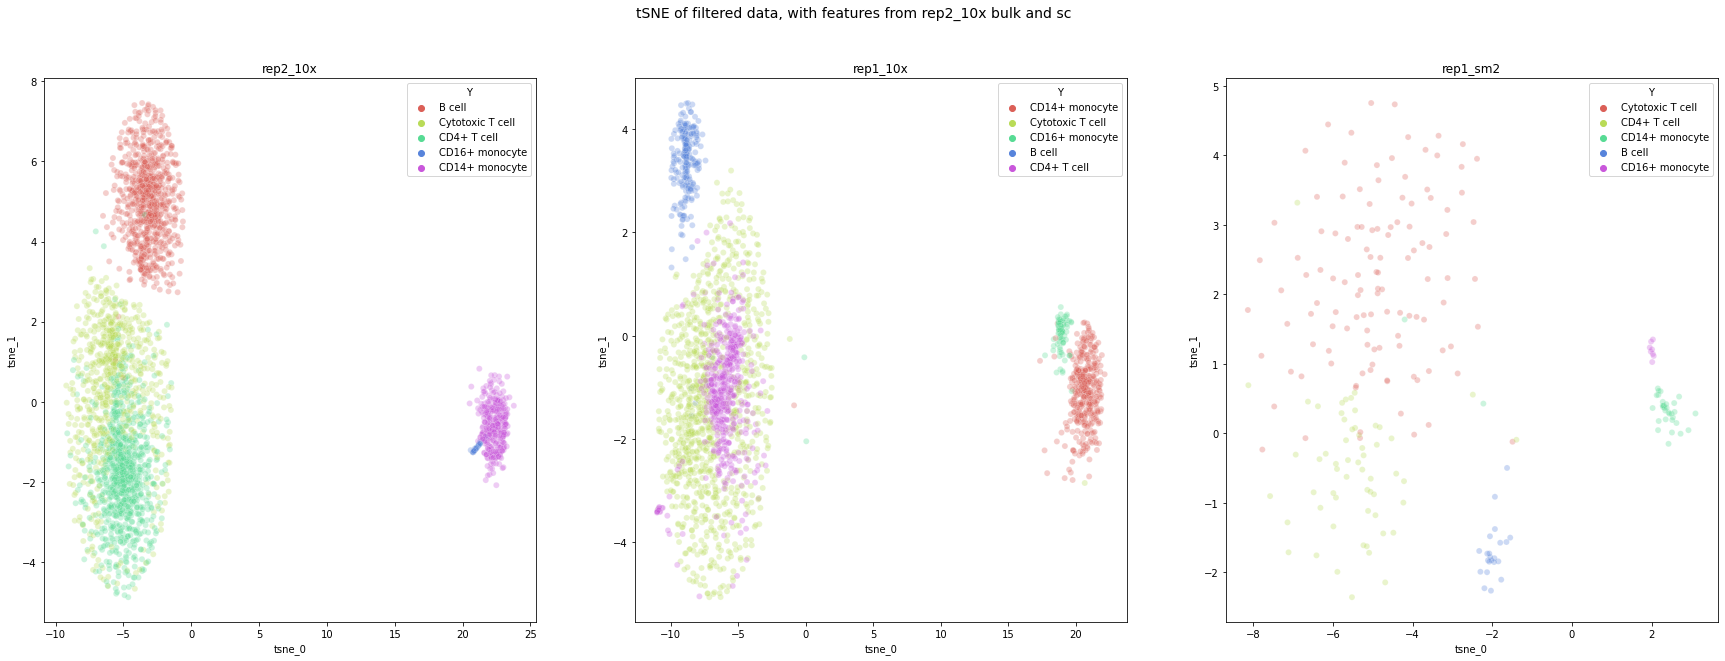

In [15]:
from matplotlib_venn import venn2

set_names = ["rep2_10x_sc", "rep2_10x_bulk"]
set_val = [set(reference_genes), set(bulk_genes)]
venn2(set_val, set_names)

rep2_10x_genes_bulk_sc = np.union1d(reference_genes, bulk_genes)


fig, axs = plt.subplots(1, 3, figsize=(30,10))


rep2_10x_plot_df = get_tsne_for_plotting(np.asarray(rep2_10x_filt[np.intersect1d(rep2_10x_genes_bulk_sc, common_genes)]))
plot_tsne(rep2_10x_plot_df, color_vec=rep2_10x_filt['CellType'].tolist(), ax=axs[0], title="rep2_10x")

rep1_10x_plot_df = get_tsne_for_plotting(np.asarray(rep1_10x_filt[np.intersect1d(rep2_10x_genes_bulk_sc, common_genes)]))
plot_tsne(rep1_10x_plot_df, color_vec=rep1_10x_filt['CellType'].tolist(), ax=axs[1], title="rep1_10x")

rep1_sm2_plot_df = get_tsne_for_plotting(np.asarray(rep1_sm2_filt[np.intersect1d(rep2_10x_genes_bulk_sc, common_genes)]))
plot_tsne(rep1_sm2_plot_df, color_vec=rep1_sm2_filt['CellType'].tolist(), ax=axs[2], title="rep1_sm2")


fig.suptitle("tSNE of filtered data, with features from rep2_10x bulk and sc", fontsize=14)

fig.show()

print(f"rep2_10x num genes: {np.intersect1d(rep2_10x_genes_bulk_sc, common_genes).shape}")
print(f"rep1_10x num genes: {np.intersect1d(rep2_10x_genes_bulk_sc, common_genes).shape}")
print(f"rep1_sm2 num genes: {np.intersect1d(rep2_10x_genes_bulk_sc, common_genes).shape}")



(3037, 2)
(3037, 2)
(2975, 2)
(2975, 2)
(253, 2)
(253, 2)
rep2_10x num genes: (10084,)
rep1_10x num genes: (10084,)
rep1_sm2 num genes: (10084,)


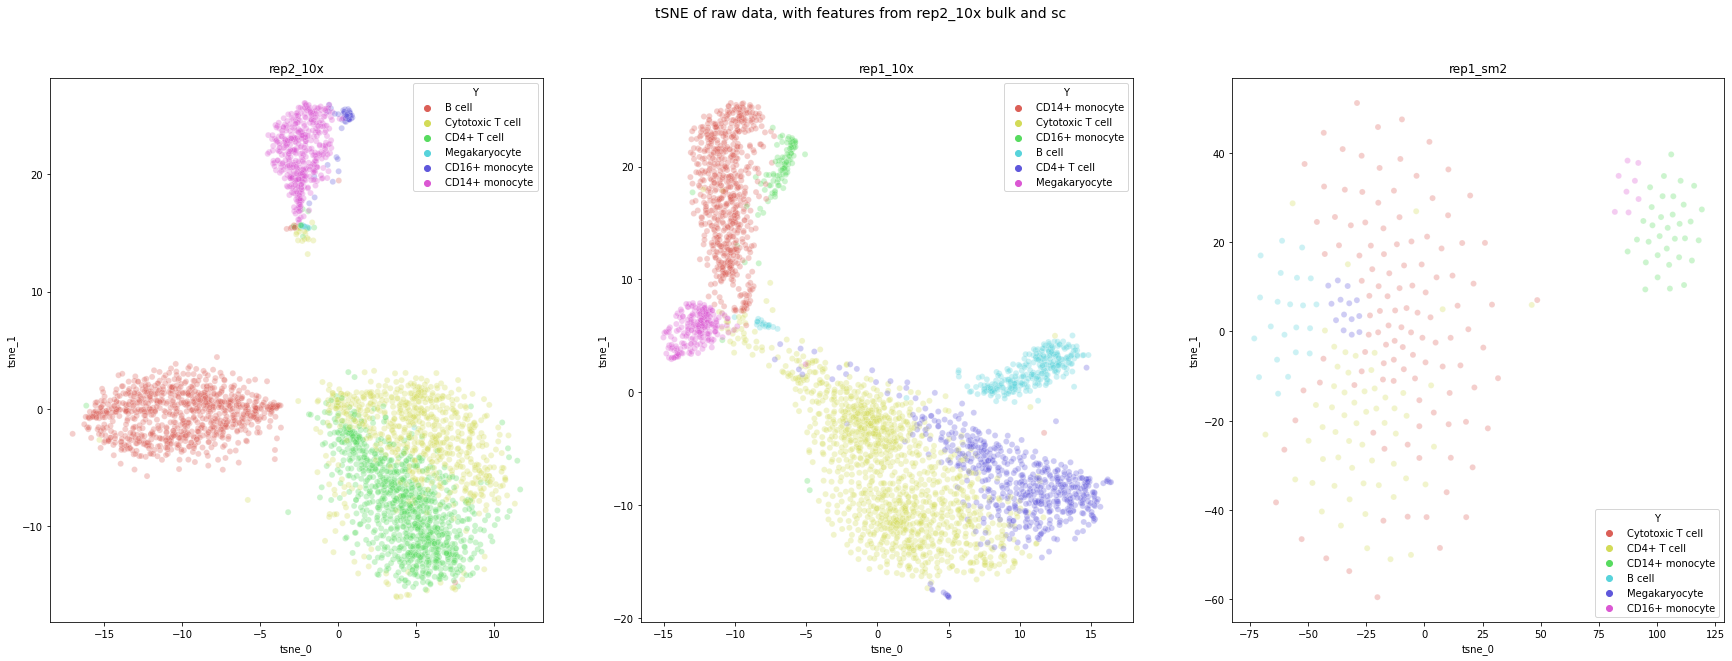

In [16]:


fig, axs = plt.subplots(1, 3, figsize=(30,10))


rep2_10x_plot_df = get_tsne_for_plotting(np.asarray(rep2_10x_expr_df[np.intersect1d(rep2_10x_genes_bulk_sc, common_genes)]))
plot_tsne(rep2_10x_plot_df, color_vec=rep2_10x_expr_df['CellType'].tolist(), ax=axs[0], title="rep2_10x")

rep1_10x_plot_df = get_tsne_for_plotting(np.asarray(rep1_10x_expr_df[np.intersect1d(rep2_10x_genes_bulk_sc, common_genes)]))
plot_tsne(rep1_10x_plot_df, color_vec=rep1_10x_expr_df['CellType'].tolist(), ax=axs[1], title="rep1_10x")

rep1_sm2_plot_df = get_tsne_for_plotting(np.asarray(rep1_sm2_expr_df[np.intersect1d(rep2_10x_genes_bulk_sc, common_genes)]))
plot_tsne(rep1_sm2_plot_df, color_vec=rep1_sm2_expr_df['CellType'].tolist(), ax=axs[2], title="rep1_sm2")


fig.suptitle("tSNE of raw data, with features from rep2_10x bulk and sc", fontsize=14)

fig.show()

print(f"rep2_10x num genes: {np.intersect1d(rep2_10x_genes_bulk_sc, common_genes).shape}")
print(f"rep1_10x num genes: {np.intersect1d(rep2_10x_genes_bulk_sc, common_genes).shape}")
print(f"rep1_sm2 num genes: {np.intersect1d(rep2_10x_genes_bulk_sc, common_genes).shape}")



In [17]:
outlier_idx = np.where(rep1_sm2_plot_df['tsne_0'] == np.min(rep1_sm2_plot_df['tsne_0']))[0][0]
val_outlier = rep1_sm2_expr_df.iloc[outlier_idx][np.intersect1d(rep2_10x_genes_bulk_sc, rep1_sm2_index_res)]
np.nanstd(val_outlier)

182.93268257700217